In [1]:
pip install -U albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (0.5.2)


In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import time

## Config

In [28]:
class config:
    experiments_folder = os.path.abspath("/content/drive/MyDrive/neurus_project/experiments")
    current_working_folder = os.path.abspath(f'/content/drive/MyDrive/neurus_project/experiments/exp_{len(os.listdir(experiments_folder))}/')
    data_path = os.path.abspath('/content/drive/MyDrive/neurus_project/')
    df_path = os.path.join(data_path, 'df.csv')
    img_path = 'dataset'
    im_size = 512
    fold = 0
    seed = 42
    lr = 0.0001
    min_lr = 1e-6
    weight_decay = 1e-6
    num_workers = 2
    verbose_step = 1
    device =  'cuda:0' 
    train_batch_size = 4
    valid_batch_size = 4
    n_epochs = 300
    verbose = True
    verbose_step = 1
    step_scheduler = False
    validation_scheduler = True
    OptimizerClass = torch.optim.AdamW
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
         mode='max',
         factor=0.5,
         patience=5,
         verbose=True, 
         threshold=0.0001,
         threshold_mode='abs',
         cooldown=0, 
         min_lr=1e-8,
         eps=1e-08
     )

## Data info

In [4]:
cd drive/MyDrive/neurus_project/dataset

/content/drive/MyDrive/neurus_project/dataset


In [5]:
print(f'We have {len(os.listdir())} files')
print(f"{len(glob.glob('*.jpg'))} images")
print(f"{len(glob.glob('*.txt'))} annotations")

We have 6770 files
3385 images
3385 annotations


In [6]:
idx2label = {0:'cat', 1: 'dog'}

In [7]:
df = pd.read_csv(config.df_path)
df.head()

filename  class_id   x1  ...  box_abs_height  box_abs_width    fold
0  shiba_inu_147.jpg         1   35  ...        0.652000       0.653333  fold_2
1  shiba_inu_150.jpg         1   80  ...        0.320000       0.358090  fold_1
2  shiba_inu_152.jpg         1   80  ...        0.296000       0.337313  fold_4
3  shiba_inu_153.jpg         1  110  ...        0.519231       0.286000  fold_1
4  shiba_inu_154.jpg         1  107  ...        0.472000       0.648352  fold_4

[5 rows x 15 columns]

In [8]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A

## Datasets, loaders and augs

In [9]:
class CatsDogsDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame,
        image_folder: os.path,
        transform: A.Compose or None):

        self.df = df.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        img_path = os.path.join(self.image_folder,
                                self.df.loc[idx, 'filename'])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        
        bbox = self.df.loc[idx, ["x1_abs", "y1_abs", "x2_abs", "y2_abs"]].values
        label = self.df.loc[idx, 'class_id']
        
        if self.transform:
            transformed = self.transform(image=image, 
                                         bboxes=[bbox], 
                                         label=[label])
            image = transformed['image']
            label = torch.tensor(transformed['label'][0])
            bbox = torch.tensor(transformed['bboxes'][0])

        sample = {'image': image,  
                  'label': label, 
                  'bbox': bbox,
                  'filename': self.df.loc[idx, 'filename']}

        return sample

In [10]:
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
        A.OneOf(
            [
                A.RandomSizedBBoxSafeCrop(config.im_size, config.im_size, p=0.5),
                A.Resize(config.im_size, config.im_size, p=0.5),
            ], p=1.
        ),
        A.HorizontalFlip(),
        A.VerticalFlip(), 
        A.ShiftScaleRotate(p=0.5),
        A.Cutout(num_holes=16, max_h_size=32, max_w_size=32, p=0.5),
        A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5)
        ]),
        A.Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225], 
                    max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ], bbox_params={'format': 'albumentations', 'label_fields': ['label']})

valid_transforms = A.Compose([
        A.Resize(config.im_size, config.im_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225], 
                    max_pixel_value=255.0, p=1.0),
        ToTensorV2(),
    ], bbox_params={'format': 'albumentations', 'label_fields': ['label']})

In [11]:
train_dataset = CatsDogsDataset(df[df['fold']!=f'fold_{config.fold}'], 
                                os.path.abspath('/content/drive/MyDrive/neurus_project/dataset/'),
                                train_transforms)
valid_dataset = CatsDogsDataset(df[df['fold']==f'fold_{config.fold}'], 
                                os.path.abspath('/content/drive/MyDrive/neurus_project/dataset/'), 
                                valid_transforms)

In [12]:
train_loader = DataLoader(train_dataset, 
                          batch_size=config.train_batch_size, 
                          shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, 
                          batch_size=config.valid_batch_size, 
                          shuffle=False, drop_last=False)

## Model

In [13]:
import torch
from torch import nn

We are going to recreate and modify VGG16 model

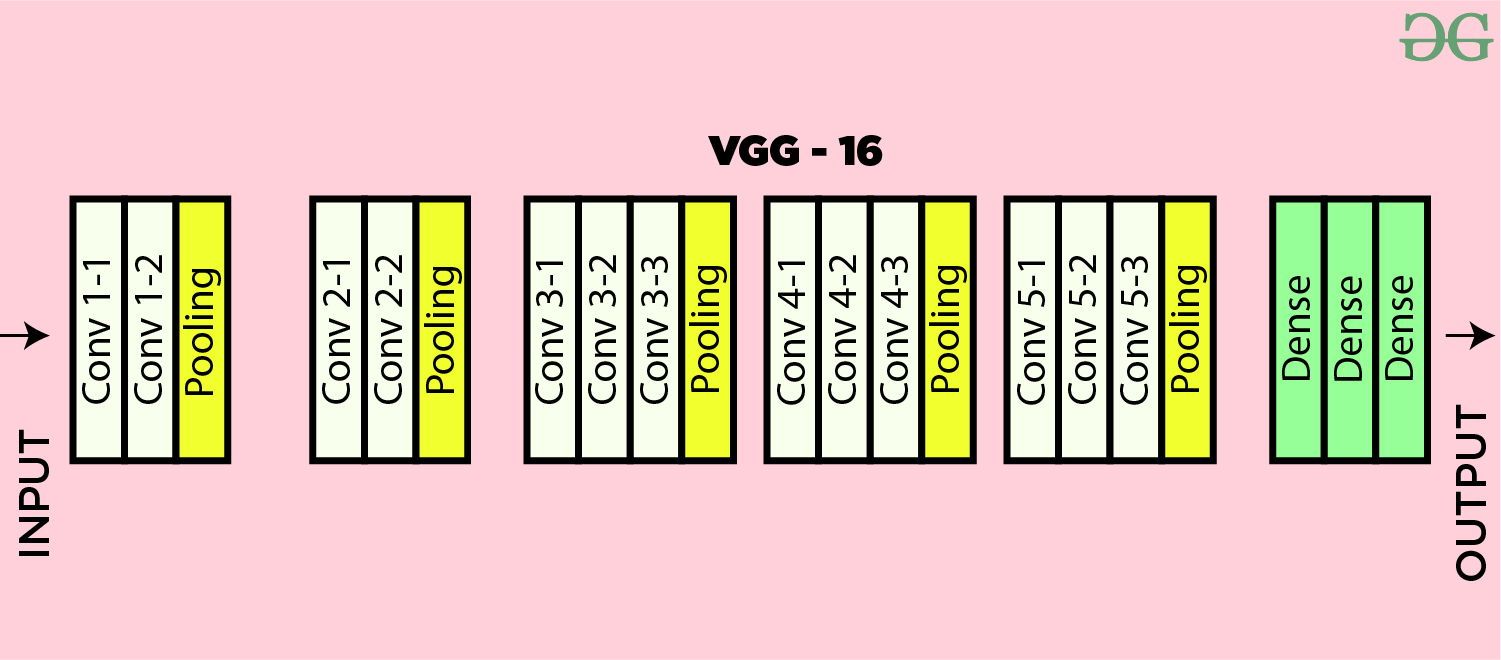

In [14]:
from torch.nn import functional as F
class CatsDogsModel(nn.Module):
    def __init__(self, n_class):
        super().__init__()


        self.conv_1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn_1 = nn.BatchNorm2d(64)
        self.mp_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn_2 = nn.BatchNorm2d(128)
        self.mp_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv_3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn_3 = nn.BatchNorm2d(256)
        self.mp_3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv_4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn_4 = nn.BatchNorm2d(512)
        self.mp_4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv_5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn_5 = nn.BatchNorm2d(512)
        self.mp_5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.av_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()


        self.classif_head = nn.Linear(512, n_class)
        self.box_head = nn.Linear(512, 4)



    def forward(self, x):

        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x = self.bn_1(x)
        x = self.mp_1(x)

        x = F.relu(self.conv_2_1(x))
        x = F.relu(self.conv_2_2(x))
        x = self.bn_2(x)
        x = self.mp_2(x)

        x = F.relu(self.conv_3_1(x))
        x = F.relu(self.conv_3_2(x))
        x = self.bn_3(x)
        x = self.mp_3(x)

        x = F.relu(self.conv_4_1(x))
        x = F.relu(self.conv_4_2(x))
        x = self.bn_4(x)
        x = self.mp_4(x)


        x = F.relu(self.conv_5_1(x))
        x = F.relu(self.conv_5_2(x))
        x = self.bn_5(x)
        x = self.mp_5(x)

        x = self.av_pool(x)
        x = self.flatten(x)

        
        label = self.classif_head(x)
        box = self.box_head(x)

        return {"label": label, 'bbox': box}


In [29]:
model = CatsDogsModel(n_class=2)

In [30]:
model.cuda()

CatsDogsModel(
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_3): MaxPool2d(kernel_size=2, stride=2, padding=0, d

## Training

In [31]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [32]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0, mode='max'):
        """
        :param patience: how many epochs to wait before stopping when metric is
               not improving
        :param min_delta: minimum difference between new metric and old metric for
               new metric to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.mode = mode

    def __call__(self, val_loss):
        if self.mode=='min':
            if self.best_loss == None:
                self.best_loss = val_loss
            elif self.best_loss - val_loss > self.min_delta:
                self.best_loss = val_loss
                self.counter = 0
            elif self.best_loss - val_loss < self.min_delta:
                self.counter += 1
                print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
                if self.counter >= self.patience:
                    print('INFO: Early stopping')
                    self.early_stop = True
        elif self.mode=='max':
            if self.best_loss == None:
                self.best_loss = val_loss
            elif self.best_loss - val_loss < self.min_delta:
                self.best_loss = val_loss
                self.counter = 0
            elif self.best_loss - val_loss > self.min_delta:
                self.counter += 1
                print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
                if self.counter >= self.patience:
                    print('INFO: Early stopping')
                    self.early_stop = True            

In [33]:
from torch.nn import CrossEntropyLoss, L1Loss, BCEWithLogitsLoss
from tqdm.notebook import tqdm, trange
from datetime import datetime
import copy
from sklearn.metrics import accuracy_score, roc_auc_score


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count




class Fitter:
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        self.base_dir = f'{config.current_working_folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_acc = -1
        self.best_summary_roc_auc = -1
        self.best_summary_iou = -1
        self.model = model
        self.device = device

        self.criterion = CrossEntropyLoss(weight=torch.tensor([2, 1], dtype=torch.float).cuda())
        self.box_criterion = L1Loss()
        param_optimizer = list(self.model.named_parameters())

        self.optimizer = config.OptimizerClass(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        history_dict = {}

        history_dict['epoch'] = []
        history_dict['train_loss'] = []
        history_dict['val_loss'] = []
        history_dict['train_lr'] = []
        history_dict['val_accuracy'] = []
        history_dict['val_roc_auc'] = []
        history_dict['train_iou'] = []
        history_dict['val_iou'] = []

        early_stopping = EarlyStopping(patience=20, min_delta=0, mode='min')

        tr = trange(self.epoch, self.config.n_epochs)
        for e in tr:
            history_dict['epoch'].append(self.epoch)
            lr = self.optimizer.param_groups[0]['lr']
            timestamp = datetime.utcnow().isoformat()
            
            if self.config.verbose:
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            train_loss, loss_trend, lr_trend, train_iou, iou_trend = self.train_epoch(train_loader)
            
            history_dict['train_loss'].append(loss_trend)
            history_dict['train_lr'].append(lr_trend)
            history_dict['train_iou'].append(iou_trend)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {train_loss.avg:.5f}, summary_iou: {train_iou.avg:.5f},  time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')
            
            t = time.time()
            val_loss, loss_trend, val_acc, acc_trend, val_roc_auc, val_iou, iou_trend  = self.validation(validation_loader)
            history_dict['val_loss'].append(loss_trend)
            history_dict['val_accuracy'].append(acc_trend)
            history_dict['val_roc_auc'].append(val_roc_auc)
            history_dict['val_iou'].append(iou_trend)
            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {val_loss.avg:.5f}, summary_acc: {val_acc.avg:.5f}, summary_roc_auc: {val_roc_auc.avg:.5f}, summary_iou: {val_iou.avg:.5f}, time: {(time.time() - t):.5f}')
            
            early_stopping(val_loss.avg)
            if early_stopping.early_stop:
                break

            if val_iou.avg > self.best_summary_iou:
                self.best_summary_iou = val_iou.avg
                self.model.eval()
                checkpoint_name = f'{self.base_dir}/fold_{self.config.fold}_best-checkpoint-{str(self.epoch).zfill(3)}epoch_iou={val_iou.avg:.3f}.bin'
                self.save(checkpoint_name)
                
                try:
                    os.remove(f)
                except:pass
                f = copy.deepcopy(checkpoint_name)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=val_iou.avg)

            self.epoch += 1

        
        plt.figure(figsize=(15, 10))
        plt.plot([np.mean(i) for i in history_dict['train_loss']], label = 'train_loss')
        plt.plot([np.mean(i) for i in history_dict['val_loss']], label = 'val_loss')
        plt.plot([np.mean(i) for i in history_dict['val_accuracy']], label = 'val_accuracy')
        plt.plot([np.mean(i) for i in history_dict['val_iou']], label = 'val_iou')
        plt.plot([np.mean(i) for i in history_dict['train_iou']], label = 'train_iou')

        plt.xlabel('Epochs')
        plt.ylabel('Loss/Accuracy')
        plt.legend()
        plt.savefig(os.path.split(self.log_path)[0]+f'/metrics.jpg')

        return history_dict

    def train_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        summary_iou = AverageMeter()
        t = time.time()
        loss_trend = []
        lr_trend = []
        iou_trend = []

        for step, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )            
            images = batch['image']
            labels = batch['label']
            bbox = batch['bbox']
            filenames = batch['filename']

            images = images.to(self.device).float()
            labels = labels.to(self.device)
            bbox = bbox.to(self.device)

            self.optimizer.zero_grad()
            output = self.model(images)
            

            pred_classes = output['label'].float()
            class_loss = self.criterion(pred_classes, labels)
            box_loss = self.box_criterion(output['bbox'].float(), bbox)

            overall_loss = class_loss + box_loss
            overall_loss.backward()

            for i in range(len(bbox)):
                try:
                    current_iou = bb_intersection_over_union(output['bbox'][i].float(), bbox[i])
                    summary_iou.update(current_iou.item(), 1)
                except:
                    print(current_iou)
            summary_loss.update(overall_loss.detach().item(), self.config.train_batch_size)
            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

            lr = self.optimizer.param_groups[0]['lr']
            loss_trend.append(summary_loss.avg)
            lr_trend.append(lr)
            iou_trend.append(summary_iou.avg)
        return summary_loss, loss_trend, lr_trend, summary_iou, iou_trend
    
    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        summary_acc = AverageMeter()
        summary_rocauc = AverageMeter()
        summary_iou = AverageMeter()
        t = time.time()

        loss_trend = []
        acc_trend = []
        iou_trend = []

        all_labels = []
        all_preds = []
        num_preds = 0

        for step, batch in tqdm(enumerate(val_loader), total=len(val_loader)):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )

            with torch.no_grad():

                images = batch['image']
                labels = batch['label']
                bbox = batch['bbox']

                images = images.to(self.device).float()
                labels = labels.to(self.device)
                bbox = bbox.to(self.device)

                output = self.model(images)
                
                for i in range(len(bbox)):
                    try:
                        current_iou = bb_intersection_over_union(output['bbox'][i].float(), bbox[i])
                        summary_iou.update(current_iou.item(), 1)
                    except:
                        pass
                pred_classes = output['label'].float()
                class_loss = self.criterion(pred_classes, labels)
                box_loss = self.box_criterion(output['bbox'][i].float(), bbox[i]) 
                
                overall_loss = class_loss+box_loss 
                summary_loss.update(overall_loss.detach().item(), self.config.valid_batch_size)

                current_acc = accuracy_score(labels.cpu().numpy(), output['label'].argmax(axis=1).cpu().numpy())
                summary_acc.update(current_acc, self.config.valid_batch_size)
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(output['label'].argmax(axis=1).cpu().numpy())

                loss_trend.append(summary_loss.avg)
                acc_trend.append(summary_acc.avg)
                iou_trend.append(summary_iou.avg)
        rocauc = roc_auc_score(all_labels, all_preds)
        summary_rocauc.update(rocauc, len(val_loader))
        return summary_loss, loss_trend, summary_acc, acc_trend, summary_rocauc, summary_iou, iou_trend
    
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_accuracy': self.best_summary_acc,
            'best_summary_roc_auc': self.best_summary_roc_auc,
            'best_summary_iou': self.best_summary_iou,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_acc = checkpoint['best_summary_accuracy']
        self.best_summary_roc_auc = checkpoint['best_summary_roc_auc']
        self.best_summary_iou = checkpoint['best_summary_iou']
        self.epoch = checkpoint['epoch'] + 1
        self.base_dir = path.split(path)[0]
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

Fitter prepared. Device is cuda:0



2021-04-18T20:39:43.365479
LR: 0.0001


Train Step 676/677, summary_loss: 0.86446, time: 109.96839
[RESULT]: Train. Epoch: 0, summary_loss: 0.86449, summary_iou: 0.64866,  time: 110.06173


Val Step 169/170, summary_loss: 0.83332, time: 14.93304
[RESULT]: Val. Epoch: 0, summary_loss: 0.83224, summary_acc: 0.61618, summary_roc_auc: 0.56961, summary_iou: 0.61976, time: 14.94932

2021-04-18T20:41:49.100946
LR: 0.0001



[RESULT]: Train. Epoch: 1, summary_loss: 0.81282, summary_iou: 0.68943,  time: 110.06998


Val Step 169/170, summary_loss: 0.83716, time: 14.82136
[RESULT]: Val. Epoch: 1, summary_loss: 0.83518, summary_acc: 0.62941, summary_roc_auc: 0.56431, summary_iou: 0.60056, time: 14.83662
INFO: Early stopping counter 1 of 20

2021-04-18T20:43:54.381661
LR: 0.0001


Train Step 676/677, summary_loss: 0.80245, time: 110.53550
[RESULT]: Train. Epoch: 2, summary_loss: 0.80257, summary_iou: 0.69190,  time: 110.62885


Val Step 169/170, summary_loss: 0.82407, time: 15.08899
[RESULT]: Val. Epoch: 2, summary_loss: 0.82334, summary_acc: 0.59412, summary_roc_auc: 0.60501, summary_iou: 0.62912, time: 15.10450

2021-04-18T20:46:00.849062
LR: 0.0001



[RESULT]: Train. Epoch: 3, summary_loss: 0.80678, summary_iou: 0.69052,  time: 110.73661


Val Step 169/170, summary_loss: 0.79862, time: 14.73544
[RESULT]: Val. Epoch: 3, summary_loss: 0.79705, summary_acc: 0.63824, summary_roc_auc: 0.61530, summary_iou: 0.66167, time: 14.74921

2021-04-18T20:48:07.060156
LR: 0.0001


Train Step 676/677, summary_loss: 0.79314, time: 110.67373
[RESULT]: Train. Epoch: 4, summary_loss: 0.79291, summary_iou: 0.69508,  time: 110.76910


Val Step 169/170, summary_loss: 0.85081, time: 14.81165
[RESULT]: Val. Epoch: 4, summary_loss: 0.84924, summary_acc: 0.57500, summary_roc_auc: 0.62227, summary_iou: 0.68774, time: 14.82582
INFO: Early stopping counter 1 of 20

2021-04-18T20:50:13.389087
LR: 0.0001



[RESULT]: Train. Epoch: 5, summary_loss: 0.78996, summary_iou: 0.69849,  time: 110.63863


Val Step 169/170, summary_loss: 0.77425, time: 15.02368
[RESULT]: Val. Epoch: 5, summary_loss: 0.77185, summary_acc: 0.66471, summary_roc_auc: 0.61417, summary_iou: 0.67449, time: 15.04050

2021-04-18T20:52:19.437971
LR: 0.0001



[RESULT]: Train. Epoch: 6, summary_loss: 0.77668, summary_iou: 0.69895,  time: 111.18848


Val Step 169/170, summary_loss: 0.78818, time: 15.08610
[RESULT]: Val. Epoch: 6, summary_loss: 0.78690, summary_acc: 0.67353, summary_roc_auc: 0.64894, summary_iou: 0.65817, time: 15.10226
INFO: Early stopping counter 1 of 20

2021-04-18T20:54:26.118887
LR: 0.0001



[RESULT]: Train. Epoch: 7, summary_loss: 0.77025, summary_iou: 0.70588,  time: 111.61010


Val Step 169/170, summary_loss: 0.85109, time: 14.95287
[RESULT]: Val. Epoch: 7, summary_loss: 0.84988, summary_acc: 0.55441, summary_roc_auc: 0.62495, summary_iou: 0.67897, time: 14.96725
INFO: Early stopping counter 2 of 20

2021-04-18T20:56:33.080836
LR: 0.0001



[RESULT]: Train. Epoch: 8, summary_loss: 0.77199, summary_iou: 0.69944,  time: 111.37975


Val Step 169/170, summary_loss: 0.78564, time: 15.33283
[RESULT]: Val. Epoch: 8, summary_loss: 0.78254, summary_acc: 0.65000, summary_roc_auc: 0.63597, summary_iou: 0.66683, time: 15.35011
INFO: Early stopping counter 3 of 20

2021-04-18T20:58:40.187631
LR: 0.0001



[RESULT]: Train. Epoch: 9, summary_loss: 0.75983, summary_iou: 0.70243,  time: 111.26580


Val Step 169/170, summary_loss: 0.72181, time: 15.20684
[RESULT]: Val. Epoch: 9, summary_loss: 0.71849, summary_acc: 0.73971, summary_roc_auc: 0.64680, summary_iou: 0.66371, time: 15.22197

2021-04-18T21:00:47.055492
LR: 0.0001



[RESULT]: Train. Epoch: 10, summary_loss: 0.74984, summary_iou: 0.70279,  time: 112.22582


Val Step 169/170, summary_loss: 0.74803, time: 15.39834
[RESULT]: Val. Epoch: 10, summary_loss: 0.74548, summary_acc: 0.71471, summary_roc_auc: 0.67062, summary_iou: 0.63465, time: 15.41378
INFO: Early stopping counter 1 of 20
Epoch    11: reducing learning rate of group 0 to 5.0000e-05.

2021-04-18T21:02:55.105568
LR: 5e-05



[RESULT]: Train. Epoch: 11, summary_loss: 0.74827, summary_iou: 0.70967,  time: 112.06214


Val Step 169/170, summary_loss: 0.69030, time: 15.36377
[RESULT]: Val. Epoch: 11, summary_loss: 0.68770, summary_acc: 0.74118, summary_roc_auc: 0.67220, summary_iou: 0.68316, time: 15.38125

2021-04-18T21:05:02.950381
LR: 5e-05



[RESULT]: Train. Epoch: 12, summary_loss: 0.74335, summary_iou: 0.70801,  time: 111.78649


Val Step 169/170, summary_loss: 0.79191, time: 15.60085
[RESULT]: Val. Epoch: 12, summary_loss: 0.78997, summary_acc: 0.66471, summary_roc_auc: 0.69798, summary_iou: 0.67435, time: 15.61713
INFO: Early stopping counter 1 of 20

2021-04-18T21:07:10.742972
LR: 5e-05


Train Step 676/677, summary_loss: 0.73317, time: 111.27825
[RESULT]: Train. Epoch: 13, summary_loss: 0.73299, summary_iou: 0.71117,  time: 111.37203


Val Step 169/170, summary_loss: 0.74205, time: 15.04639
[RESULT]: Val. Epoch: 13, summary_loss: 0.73904, summary_acc: 0.72647, summary_roc_auc: 0.71698, summary_iou: 0.67143, time: 15.06364
INFO: Early stopping counter 2 of 20

2021-04-18T21:09:17.558526
LR: 5e-05



[RESULT]: Train. Epoch: 14, summary_loss: 0.72934, summary_iou: 0.70948,  time: 110.89342


Val Step 169/170, summary_loss: 0.68946, time: 15.09994
[RESULT]: Val. Epoch: 14, summary_loss: 0.68690, summary_acc: 0.73971, summary_roc_auc: 0.66437, summary_iou: 0.68202, time: 15.11479

2021-04-18T21:11:23.943557
LR: 5e-05



[RESULT]: Train. Epoch: 15, summary_loss: 0.72529, summary_iou: 0.71086,  time: 111.17282


Val Step 169/170, summary_loss: 0.82171, time: 14.88256
[RESULT]: Val. Epoch: 15, summary_loss: 0.81914, summary_acc: 0.63824, summary_roc_auc: 0.69910, summary_iou: 0.67017, time: 14.89888
INFO: Early stopping counter 1 of 20

2021-04-18T21:13:30.406111
LR: 5e-05



[RESULT]: Train. Epoch: 16, summary_loss: 0.71499, summary_iou: 0.71155,  time: 110.09157


Val Step 169/170, summary_loss: 0.69580, time: 14.84422
[RESULT]: Val. Epoch: 16, summary_loss: 0.69302, summary_acc: 0.72941, summary_roc_auc: 0.68802, summary_iou: 0.67989, time: 14.86228
INFO: Early stopping counter 2 of 20
Epoch    17: reducing learning rate of group 0 to 2.5000e-05.

2021-04-18T21:15:35.740489
LR: 2.5e-05



[RESULT]: Train. Epoch: 17, summary_loss: 0.69600, summary_iou: 0.71451,  time: 110.17311


Val Step 169/170, summary_loss: 0.66189, time: 15.09491
[RESULT]: Val. Epoch: 17, summary_loss: 0.65948, summary_acc: 0.75147, summary_roc_auc: 0.74452, summary_iou: 0.69592, time: 15.11278

2021-04-18T21:17:41.741250
LR: 2.5e-05



[RESULT]: Train. Epoch: 18, summary_loss: 0.70027, summary_iou: 0.71338,  time: 110.26781


Val Step 169/170, summary_loss: 0.71273, time: 15.16264
[RESULT]: Val. Epoch: 18, summary_loss: 0.71017, summary_acc: 0.73971, summary_roc_auc: 0.74277, summary_iou: 0.66919, time: 15.17763
INFO: Early stopping counter 1 of 20

2021-04-18T21:19:47.576627
LR: 2.5e-05


Train Step 676/677, summary_loss: 0.68043, time: 111.11199
[RESULT]: Train. Epoch: 19, summary_loss: 0.68040, summary_iou: 0.71692,  time: 111.20555


Val Step 169/170, summary_loss: 0.71690, time: 15.21869
[RESULT]: Val. Epoch: 19, summary_loss: 0.71413, summary_acc: 0.71618, summary_roc_auc: 0.72304, summary_iou: 0.69349, time: 15.23903
INFO: Early stopping counter 2 of 20

2021-04-18T21:21:54.417337
LR: 2.5e-05



[RESULT]: Train. Epoch: 20, summary_loss: 0.68000, summary_iou: 0.71712,  time: 111.99751


Val Step 169/170, summary_loss: 0.69569, time: 15.34115
[RESULT]: Val. Epoch: 20, summary_loss: 0.69260, summary_acc: 0.73088, summary_roc_auc: 0.71881, summary_iou: 0.69091, time: 15.35659
INFO: Early stopping counter 3 of 20

2021-04-18T21:24:02.144976
LR: 2.5e-05



[RESULT]: Train. Epoch: 21, summary_loss: 0.67153, summary_iou: 0.71677,  time: 111.89145


Val Step 169/170, summary_loss: 0.66499, time: 15.34150
[RESULT]: Val. Epoch: 21, summary_loss: 0.66205, summary_acc: 0.75588, summary_roc_auc: 0.74231, summary_iou: 0.69214, time: 15.35793
INFO: Early stopping counter 4 of 20

2021-04-18T21:26:09.803187
LR: 2.5e-05


Train Step 676/677, summary_loss: 0.67462, time: 112.41548
[RESULT]: Train. Epoch: 22, summary_loss: 0.67442, summary_iou: 0.71787,  time: 112.51095


Val Step 169/170, summary_loss: 0.67934, time: 15.45842
[RESULT]: Val. Epoch: 22, summary_loss: 0.67587, summary_acc: 0.72794, summary_roc_auc: 0.74102, summary_iou: 0.69416, time: 15.47478
INFO: Early stopping counter 5 of 20

2021-04-18T21:28:18.193395
LR: 2.5e-05



[RESULT]: Train. Epoch: 23, summary_loss: 0.67041, summary_iou: 0.71872,  time: 111.64386


Val Step 169/170, summary_loss: 0.67283, time: 15.31504
[RESULT]: Val. Epoch: 23, summary_loss: 0.66990, summary_acc: 0.75294, summary_roc_auc: 0.74694, summary_iou: 0.68023, time: 15.32986
INFO: Early stopping counter 6 of 20
Epoch    24: reducing learning rate of group 0 to 1.2500e-05.

2021-04-18T21:30:25.583701
LR: 1.25e-05


Train Step 676/677, summary_loss: 0.64383, time: 111.37677
[RESULT]: Train. Epoch: 24, summary_loss: 0.64435, summary_iou: 0.72102,  time: 111.47090


Val Step 169/170, summary_loss: 0.67490, time: 15.20616
[RESULT]: Val. Epoch: 24, summary_loss: 0.67148, summary_acc: 0.73971, summary_roc_auc: 0.73331, summary_iou: 0.69506, time: 15.22357
INFO: Early stopping counter 7 of 20

2021-04-18T21:32:32.660346
LR: 1.25e-05



[RESULT]: Train. Epoch: 25, summary_loss: 0.65460, summary_iou: 0.71998,  time: 111.62170


Val Step 169/170, summary_loss: 0.62786, time: 15.46152
[RESULT]: Val. Epoch: 25, summary_loss: 0.62487, summary_acc: 0.78971, summary_roc_auc: 0.76407, summary_iou: 0.69373, time: 15.47594

2021-04-18T21:34:40.142076
LR: 1.25e-05



[RESULT]: Train. Epoch: 26, summary_loss: 0.64136, summary_iou: 0.72007,  time: 111.95148


Val Step 169/170, summary_loss: 0.67078, time: 15.11208
[RESULT]: Val. Epoch: 26, summary_loss: 0.66731, summary_acc: 0.74559, summary_roc_auc: 0.75378, summary_iou: 0.69127, time: 15.12818
INFO: Early stopping counter 1 of 20

2021-04-18T21:36:47.603673
LR: 1.25e-05



[RESULT]: Train. Epoch: 27, summary_loss: 0.63626, summary_iou: 0.71952,  time: 111.43545


Val Step 169/170, summary_loss: 0.66469, time: 15.25004
[RESULT]: Val. Epoch: 27, summary_loss: 0.66123, summary_acc: 0.73382, summary_roc_auc: 0.73851, summary_iou: 0.69474, time: 15.26725
INFO: Early stopping counter 2 of 20

2021-04-18T21:38:54.694524
LR: 1.25e-05


Train Step 676/677, summary_loss: 0.62759, time: 110.97703
[RESULT]: Train. Epoch: 28, summary_loss: 0.62734, summary_iou: 0.71856,  time: 111.07161


Val Step 169/170, summary_loss: 0.63747, time: 15.18891
[RESULT]: Val. Epoch: 28, summary_loss: 0.63440, summary_acc: 0.75294, summary_roc_auc: 0.74694, summary_iou: 0.69812, time: 15.20419
INFO: Early stopping counter 3 of 20

2021-04-18T21:41:01.703325
LR: 1.25e-05



[RESULT]: Train. Epoch: 29, summary_loss: 0.63731, summary_iou: 0.72130,  time: 111.47075


Val Step 169/170, summary_loss: 0.63776, time: 15.25079
[RESULT]: Val. Epoch: 29, summary_loss: 0.63459, summary_acc: 0.77206, summary_roc_auc: 0.75671, summary_iou: 0.69419, time: 15.26928
INFO: Early stopping counter 4 of 20

2021-04-18T21:43:08.838564
LR: 1.25e-05



[RESULT]: Train. Epoch: 30, summary_loss: 0.63292, summary_iou: 0.71908,  time: 110.75832


Val Step 169/170, summary_loss: 0.61430, time: 15.15403
[RESULT]: Val. Epoch: 30, summary_loss: 0.61129, summary_acc: 0.77500, summary_roc_auc: 0.74803, summary_iou: 0.68586, time: 15.16987

2021-04-18T21:45:15.178850
LR: 1.25e-05


Train Step 676/677, summary_loss: 0.62786, time: 110.91856
[RESULT]: Train. Epoch: 31, summary_loss: 0.62739, summary_iou: 0.72252,  time: 111.01233


Val Step 169/170, summary_loss: 0.69426, time: 15.28292
[RESULT]: Val. Epoch: 31, summary_loss: 0.69119, summary_acc: 0.73824, summary_roc_auc: 0.74306, summary_iou: 0.70627, time: 15.29844
INFO: Early stopping counter 1 of 20

2021-04-18T21:47:22.203316
LR: 1.25e-05


Train Step 676/677, summary_loss: 0.61362, time: 110.78756
[RESULT]: Train. Epoch: 32, summary_loss: 0.61336, summary_iou: 0.72514,  time: 110.88099


Val Step 169/170, summary_loss: 0.65104, time: 15.00225
[RESULT]: Val. Epoch: 32, summary_loss: 0.64761, summary_acc: 0.75147, summary_roc_auc: 0.74993, summary_iou: 0.69371, time: 15.01917
INFO: Early stopping counter 2 of 20

2021-04-18T21:49:28.485933
LR: 1.25e-05



[RESULT]: Train. Epoch: 33, summary_loss: 0.60899, summary_iou: 0.72056,  time: 110.72436


Val Step 169/170, summary_loss: 0.62110, time: 15.09723
[RESULT]: Val. Epoch: 33, summary_loss: 0.61771, summary_acc: 0.77941, summary_roc_auc: 0.75527, summary_iou: 0.68324, time: 15.11275
INFO: Early stopping counter 3 of 20

2021-04-18T21:51:34.707027
LR: 1.25e-05


Train Step 676/677, summary_loss: 0.62536, time: 111.47571
[RESULT]: Train. Epoch: 34, summary_loss: 0.62542, summary_iou: 0.72333,  time: 111.56983


Val Step 169/170, summary_loss: 0.66116, time: 15.29673
[RESULT]: Val. Epoch: 34, summary_loss: 0.65774, summary_acc: 0.75588, summary_roc_auc: 0.76393, summary_iou: 0.68645, time: 15.31357
INFO: Early stopping counter 4 of 20

2021-04-18T21:53:41.973626
LR: 1.25e-05



[RESULT]: Train. Epoch: 35, summary_loss: 0.61706, summary_iou: 0.72166,  time: 111.37754


Val Step 169/170, summary_loss: 0.62095, time: 15.12098
[RESULT]: Val. Epoch: 35, summary_loss: 0.61762, summary_acc: 0.78971, summary_roc_auc: 0.76542, summary_iou: 0.69542, time: 15.13650
INFO: Early stopping counter 5 of 20

2021-04-18T21:55:48.866287
LR: 1.25e-05



[RESULT]: Train. Epoch: 36, summary_loss: 0.62141, summary_iou: 0.72292,  time: 110.45982


Val Step 169/170, summary_loss: 0.63279, time: 15.28231
[RESULT]: Val. Epoch: 36, summary_loss: 0.62957, summary_acc: 0.77941, summary_roc_auc: 0.76879, summary_iou: 0.69225, time: 15.29860
INFO: Early stopping counter 6 of 20

2021-04-18T21:57:55.024803
LR: 1.25e-05



[RESULT]: Train. Epoch: 37, summary_loss: 0.60247, summary_iou: 0.72278,  time: 112.18846


Val Step 169/170, summary_loss: 0.59948, time: 15.61496
[RESULT]: Val. Epoch: 37, summary_loss: 0.59637, summary_acc: 0.80294, summary_roc_auc: 0.77905, summary_iou: 0.70152, time: 15.62988
Epoch    38: reducing learning rate of group 0 to 6.2500e-06.

2021-04-18T22:00:03.242317
LR: 6.25e-06


Train Step 676/677, summary_loss: 0.58691, time: 114.12343
[RESULT]: Train. Epoch: 38, summary_loss: 0.58712, summary_iou: 0.72305,  time: 114.21833


Val Step 169/170, summary_loss: 0.60145, time: 16.23741
[RESULT]: Val. Epoch: 38, summary_loss: 0.59841, summary_acc: 0.79118, summary_roc_auc: 0.76514, summary_iou: 0.69964, time: 16.25423
INFO: Early stopping counter 1 of 20

2021-04-18T22:02:14.137616
LR: 6.25e-06


Train Step 676/677, summary_loss: 0.61039, time: 116.06994
[RESULT]: Train. Epoch: 39, summary_loss: 0.61071, summary_iou: 0.72412,  time: 116.16492


Val Step 169/170, summary_loss: 0.64715, time: 16.44156
[RESULT]: Val. Epoch: 39, summary_loss: 0.64370, summary_acc: 0.75147, summary_roc_auc: 0.75398, summary_iou: 0.70008, time: 16.46053
INFO: Early stopping counter 2 of 20

2021-04-18T22:04:27.191952
LR: 6.25e-06



[RESULT]: Train. Epoch: 40, summary_loss: 0.59263, summary_iou: 0.72471,  time: 116.14824


Val Step 169/170, summary_loss: 0.63795, time: 16.49734
[RESULT]: Val. Epoch: 40, summary_loss: 0.63464, summary_acc: 0.78088, summary_roc_auc: 0.77796, summary_iou: 0.69111, time: 16.51303
INFO: Early stopping counter 3 of 20

2021-04-18T22:06:40.279891
LR: 6.25e-06


Train Step 676/677, summary_loss: 0.60097, time: 116.34320
[RESULT]: Train. Epoch: 41, summary_loss: 0.60033, summary_iou: 0.72377,  time: 116.43788


Val Step 169/170, summary_loss: 0.58989, time: 16.27338
[RESULT]: Val. Epoch: 41, summary_loss: 0.58669, summary_acc: 0.78971, summary_roc_auc: 0.77218, summary_iou: 0.69845, time: 16.29289

2021-04-18T22:08:53.431672
LR: 6.25e-06


Train Step 676/677, summary_loss: 0.59601, time: 115.72437
[RESULT]: Train. Epoch: 42, summary_loss: 0.59603, summary_iou: 0.72433,  time: 115.81856


Val Step 169/170, summary_loss: 0.68375, time: 16.23464
[RESULT]: Val. Epoch: 42, summary_loss: 0.68004, summary_acc: 0.74853, summary_roc_auc: 0.76267, summary_iou: 0.69356, time: 16.25394
INFO: Early stopping counter 1 of 20

2021-04-18T22:11:05.914526
LR: 6.25e-06


Train Step 676/677, summary_loss: 0.59398, time: 115.48706
[RESULT]: Train. Epoch: 43, summary_loss: 0.59516, summary_iou: 0.72400,  time: 115.58108


Val Step 169/170, summary_loss: 0.64936, time: 16.30810
[RESULT]: Val. Epoch: 43, summary_loss: 0.64582, summary_acc: 0.75735, summary_roc_auc: 0.77175, summary_iou: 0.69995, time: 16.32778
INFO: Early stopping counter 2 of 20
Epoch    44: reducing learning rate of group 0 to 3.1250e-06.

2021-04-18T22:13:18.253060
LR: 3.125e-06



[RESULT]: Train. Epoch: 44, summary_loss: 0.58669, summary_iou: 0.72523,  time: 115.92447


Val Step 169/170, summary_loss: 0.59629, time: 16.00909
[RESULT]: Val. Epoch: 44, summary_loss: 0.59293, summary_acc: 0.78676, summary_roc_auc: 0.77411, summary_iou: 0.69568, time: 16.02564
INFO: Early stopping counter 3 of 20

2021-04-18T22:15:30.610299
LR: 3.125e-06


Train Step 676/677, summary_loss: 0.58480, time: 114.94751
[RESULT]: Train. Epoch: 45, summary_loss: 0.58454, summary_iou: 0.72459,  time: 115.04373


Val Step 169/170, summary_loss: 0.61118, time: 16.49007
[RESULT]: Val. Epoch: 45, summary_loss: 0.60787, summary_acc: 0.77794, summary_roc_auc: 0.76367, summary_iou: 0.70011, time: 16.50949
INFO: Early stopping counter 4 of 20

2021-04-18T22:17:42.586233
LR: 3.125e-06


Train Step 676/677, summary_loss: 0.56351, time: 116.01362
[RESULT]: Train. Epoch: 46, summary_loss: 0.56327, summary_iou: 0.72382,  time: 116.10949


Val Step 169/170, summary_loss: 0.62717, time: 16.69339
[RESULT]: Val. Epoch: 46, summary_loss: 0.62381, summary_acc: 0.78382, summary_roc_auc: 0.76928, summary_iou: 0.70414, time: 16.70996
INFO: Early stopping counter 5 of 20

2021-04-18T22:19:55.845758
LR: 3.125e-06


Train Step 676/677, summary_loss: 0.59172, time: 116.35242
[RESULT]: Train. Epoch: 47, summary_loss: 0.59177, summary_iou: 0.72439,  time: 116.45014


Val Step 169/170, summary_loss: 0.72431, time: 16.82073
[RESULT]: Val. Epoch: 47, summary_loss: 0.72025, summary_acc: 0.72647, summary_roc_auc: 0.76428, summary_iou: 0.69749, time: 16.83691
INFO: Early stopping counter 6 of 20

2021-04-18T22:22:09.561463
LR: 3.125e-06


Train Step 676/677, summary_loss: 0.57425, time: 115.81655
[RESULT]: Train. Epoch: 48, summary_loss: 0.57397, summary_iou: 0.72573,  time: 115.91084


Val Step 169/170, summary_loss: 0.61880, time: 16.33120
[RESULT]: Val. Epoch: 48, summary_loss: 0.61556, summary_acc: 0.78971, summary_roc_auc: 0.77894, summary_iou: 0.69923, time: 16.34905
INFO: Early stopping counter 7 of 20

2021-04-18T22:24:22.238053
LR: 3.125e-06



[RESULT]: Train. Epoch: 49, summary_loss: 0.56649, summary_iou: 0.72325,  time: 116.99917


Val Step 169/170, summary_loss: 0.61183, time: 16.58067
[RESULT]: Val. Epoch: 49, summary_loss: 0.60862, summary_acc: 0.78971, summary_roc_auc: 0.78975, summary_iou: 0.70056, time: 16.59858
INFO: Early stopping counter 8 of 20
Epoch    50: reducing learning rate of group 0 to 1.5625e-06.

2021-04-18T22:26:36.250079
LR: 1.5625e-06


Train Step 676/677, summary_loss: 0.56557, time: 116.42136
[RESULT]: Train. Epoch: 50, summary_loss: 0.56580, summary_iou: 0.72613,  time: 116.51636


Val Step 169/170, summary_loss: 0.60201, time: 16.45132
[RESULT]: Val. Epoch: 50, summary_loss: 0.59881, summary_acc: 0.79118, summary_roc_auc: 0.78135, summary_iou: 0.70127, time: 16.46861
INFO: Early stopping counter 9 of 20

2021-04-18T22:28:49.672396
LR: 1.5625e-06



[RESULT]: Train. Epoch: 51, summary_loss: 0.57660, summary_iou: 0.72294,  time: 114.76477


Val Step 169/170, summary_loss: 0.60728, time: 15.72435
[RESULT]: Val. Epoch: 51, summary_loss: 0.60401, summary_acc: 0.78529, summary_roc_auc: 0.76764, summary_iou: 0.70081, time: 15.74211
INFO: Early stopping counter 10 of 20

2021-04-18T22:31:00.593949
LR: 1.5625e-06



[RESULT]: Train. Epoch: 52, summary_loss: 0.57508, summary_iou: 0.72523,  time: 115.47253


Val Step 169/170, summary_loss: 0.61535, time: 16.28304
[RESULT]: Val. Epoch: 52, summary_loss: 0.61200, summary_acc: 0.79118, summary_roc_auc: 0.77189, summary_iou: 0.69885, time: 16.30036
INFO: Early stopping counter 11 of 20

2021-04-18T22:33:12.769457
LR: 1.5625e-06



[RESULT]: Train. Epoch: 53, summary_loss: 0.55755, summary_iou: 0.72797,  time: 115.31746


Val Step 169/170, summary_loss: 0.59981, time: 16.26943
[RESULT]: Val. Epoch: 53, summary_loss: 0.59684, summary_acc: 0.79706, summary_roc_auc: 0.78426, summary_iou: 0.70036, time: 16.28709
INFO: Early stopping counter 12 of 20

2021-04-18T22:35:24.793956
LR: 1.5625e-06



[RESULT]: Train. Epoch: 54, summary_loss: 0.56763, summary_iou: 0.72474,  time: 113.63245


Val Step 169/170, summary_loss: 0.61721, time: 16.25570
[RESULT]: Val. Epoch: 54, summary_loss: 0.61404, summary_acc: 0.79559, summary_roc_auc: 0.78319, summary_iou: 0.69683, time: 16.27358
INFO: Early stopping counter 13 of 20

2021-04-18T22:37:35.114709
LR: 1.5625e-06


Train Step 676/677, summary_loss: 0.56579, time: 116.80100
[RESULT]: Train. Epoch: 55, summary_loss: 0.56570, summary_iou: 0.72836,  time: 116.89616


Val Step 169/170, summary_loss: 0.66867, time: 16.19325
[RESULT]: Val. Epoch: 55, summary_loss: 0.66509, summary_acc: 0.77059, summary_roc_auc: 0.77187, summary_iou: 0.69859, time: 16.21233
INFO: Early stopping counter 14 of 20
Epoch    56: reducing learning rate of group 0 to 7.8125e-07.

2021-04-18T22:39:48.640166
LR: 7.8125e-07



[RESULT]: Train. Epoch: 56, summary_loss: 0.56909, summary_iou: 0.72483,  time: 116.27296


Val Step 169/170, summary_loss: 0.67989, time: 16.33212
[RESULT]: Val. Epoch: 56, summary_loss: 0.67627, summary_acc: 0.76765, summary_roc_auc: 0.78055, summary_iou: 0.69534, time: 16.35099
INFO: Early stopping counter 15 of 20

2021-04-18T22:42:01.665258
LR: 7.8125e-07


Train Step 676/677, summary_loss: 0.57492, time: 116.34848
[RESULT]: Train. Epoch: 57, summary_loss: 0.57461, summary_iou: 0.72685,  time: 116.44350


Val Step 169/170, summary_loss: 0.67951, time: 16.01747
[RESULT]: Val. Epoch: 57, summary_loss: 0.67590, summary_acc: 0.77059, summary_roc_auc: 0.78133, summary_iou: 0.70104, time: 16.03410
INFO: Early stopping counter 16 of 20

2021-04-18T22:44:14.557884
LR: 7.8125e-07



[RESULT]: Train. Epoch: 58, summary_loss: 0.55766, summary_iou: 0.72595,  time: 113.89199


Val Step 169/170, summary_loss: 0.66817, time: 15.83856
[RESULT]: Val. Epoch: 58, summary_loss: 0.66457, summary_acc: 0.76176, summary_roc_auc: 0.76684, summary_iou: 0.69804, time: 15.85477
INFO: Early stopping counter 17 of 20

2021-04-18T22:46:24.726884
LR: 7.8125e-07


Train Step 676/677, summary_loss: 0.56247, time: 115.41585
[RESULT]: Train. Epoch: 59, summary_loss: 0.56326, summary_iou: 0.72429,  time: 115.51058


Val Step 169/170, summary_loss: 0.67979, time: 16.20385
[RESULT]: Val. Epoch: 59, summary_loss: 0.67613, summary_acc: 0.76029, summary_roc_auc: 0.76983, summary_iou: 0.69535, time: 16.22242
INFO: Early stopping counter 18 of 20

2021-04-18T22:48:36.895451
LR: 7.8125e-07


Train Step 676/677, summary_loss: 0.56806, time: 115.96532
[RESULT]: Train. Epoch: 60, summary_loss: 0.56881, summary_iou: 0.72458,  time: 116.06122


Val Step 169/170, summary_loss: 0.60140, time: 16.17909
[RESULT]: Val. Epoch: 60, summary_loss: 0.59826, summary_acc: 0.79706, summary_roc_auc: 0.77885, summary_iou: 0.70370, time: 16.20062
INFO: Early stopping counter 19 of 20

2021-04-18T22:50:49.704093
LR: 7.8125e-07


Train Step 676/677, summary_loss: 0.55594, time: 116.34287
[RESULT]: Train. Epoch: 61, summary_loss: 0.55590, summary_iou: 0.72670,  time: 116.43749


Val Step 169/170, summary_loss: 0.62911, time: 16.40566
[RESULT]: Val. Epoch: 61, summary_loss: 0.62575, summary_acc: 0.78529, summary_roc_auc: 0.77440, summary_iou: 0.69910, time: 16.42053
INFO: Early stopping counter 20 of 20
INFO: Early stopping


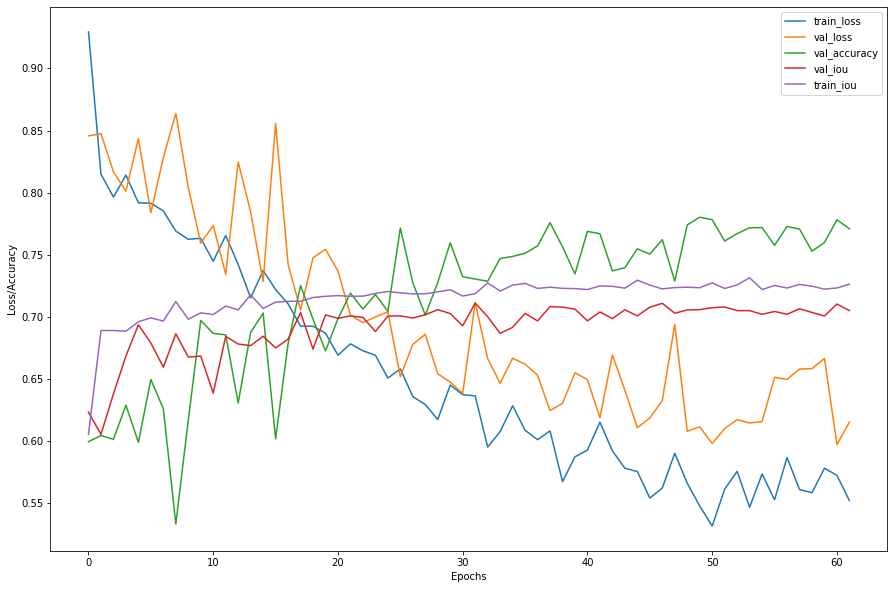

In [34]:
fitter = Fitter(model=model, device=config.device, config=config)  
history_dict = fitter.fit(train_loader, valid_loader)

## Evaluating

In [36]:
PATH = config.current_working_folder
filename = glob.glob(config.current_working_folder+'/*best-checkpoint*.bin')[1]
model.load_state_dict(torch.load(filename)['model_state_dict'])
model.eval()

CatsDogsModel(
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_3): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [37]:
valid_loader = DataLoader(valid_dataset, 
                          batch_size=config.valid_batch_size, 
                          shuffle=True, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


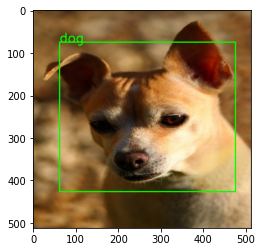

In [41]:
idx = 0
res = next(iter(valid_loader))
with torch.no_grad():
    out = model(torch.unsqueeze(res['image'][idx], 0).cuda())

img = res['image'][idx].detach().cpu().permute(1, 2, 0).numpy()
mean=[0.485, 0.456, 0.406] 
std=[0.229, 0.224, 0.225]
img = (img*std+mean)
img = img.copy()

bbox = ([int(i.item()) for i in (out['bbox'][0]*config.im_size)])

cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
cv2.putText(img, idx2label[out['label'].argmax(1).item()], 
            (bbox[0], bbox[1]), 
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
            color=(0, 255, 0), thickness=2, 
            lineType=cv2.LINE_AA)
plt.imshow(img)

In [42]:
loss, _, acc, _, rocauc, iou, _ = fitter.validation(valid_loader)
print(f'MeanIOU = {iou.avg:.3f}')
print(f'Mean accuracy = {acc.avg:.3f}')
print(f'Mean ROC-AUC = {rocauc.avg:.3f}')
print(f'Mean Loss = {loss.avg:.3f}')

Val Step 168/169, summary_loss: 0.67767, time: 15.58931
MeanIOU = 0.707
Mean accuracy = 0.738
Mean ROC-AUC = 0.744
Mean Loss = 0.676


In [43]:
device = torch.device('cuda')
model.to(device)
dummy_input = torch.randn(1, 3, config.im_size, config.im_size, dtype=torch.float).to(device)
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 300
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
   _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
  for rep in range(repetitions):
     starter.record()
     _ = model(dummy_input)
     ender.record()
     # WAIT FOR GPU SYNC
     torch.cuda.synchronize()
     curr_time = starter.elapsed_time(ender)
     timings[rep] = curr_time
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(f"inference time is {mean_syn}ms")

inference time is 6.805766832033793ms
